# Taller 2.
## Oscar Eduardo Mejia 
### 201516790
***


# Marco Teorico
***

Para este taller, se modelara un *KART ELECTRICO* que acelera desde el reposo y cuando se llegue a la velocidad maxima se modelara en el frenado del mismo.

**Formulas**  
1. Aceleración: 
>$(M+M_r)a_k = \frac{T_eN_e\eta_t}{r}-{R_x}-D_A$ 
  
>donde:  
>* $T_e$ : Torque dado por el motor
>* $N_e$ : Relación del sistema de trasmision
>* $\eta_T$: Eficiencia del sistema de trasmision
>* $R_x$: Resistencia a la rodadura  
>* $D_A$: Fuerza de arrastre aerodinamico
>* $M_r$: Masa equivalente de los componentes rotativos

2. Frenado:
>$(M+M_r)a_k = F_b-{R_x}-D_A$ 
  
>donde:  
>* $F_b$: Fuerza total del frenado aplicada en llantas delanteras y llantas traseras
>>$F_{bd}= \mu_c\dfrac{w}{l}*(l-a+h*\mu_c) $  
>>$F_{bt}= \mu_c\dfrac{w}{l}*(a+h*\mu_c) $

>>donde:  
>>* $\mu_c$: Coeficiente de adherencia
>>* $w$: Peso del kart junto al conductor
>>* $l$: Distancia de eje de las llantas traseras y delanteras 
>>* $a$: Distancia del centro de gravedad al eje de la llanta trasera
>>* $h$: Altura del centro de gravedad  

3. Torque:
>$T=\cfrac{-3.6134*10^{-8}*(\omega_0^{3})+2.9953*10^{-5}*(\omega_0^{2})+(1.6696*\omega_0)+5.4706*10^{-1}}{\omega_1}$  
>>donde:  
>>* $\omega_0$: Velocidad Angular en RPM
>>* $\omega_1$: Velocidad Angular en rad/s  

** Calculo de posición y velocidad **  

Para el calculo de la velocidad y la posicion se realizara una integración numerica por medio de la función **odeint**.


In [75]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import string
import matplotlib.cm as cm
import os
import pandas as pd
from scipy import ndimage
from scipy.integrate import odeint
import plotly.plotly as py
import cufflinks as cf

Populating the interactive namespace from numpy and matplotlib


Variables a Modificar

In [76]:
masa=152.0 # masa del Kart (kg)
ng=3.4 # Relación de Transmisión
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)
mu_c=1 #coeficiente de adherencia de las ruedas

# Variables de tiempo
t_in=0 #Tiempo incial de analisis
t_acel=100 #Tiempo final para el analisis de la aceleracion
t_fren=5 #Tiempo final para el analisis del freno
deltat=0.001 # Paso del tiempo

## No modificiar de aqui hacia abajo

A continuacion se definen parametros geometricos y fisicos del carro y algunas constantes relacionadas a los neumaticos y la carretera.  
Adicionalmente las funciones para el calculo de fuerza.
***
__Nota:__ Las graficas se encuentran al final del documento.

### Datos geometricos y caracteristicas fisicas del kart y sus datos

In [77]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
#dp=11.0 # Dientes del piñon
#dpl=39.0 # Dientes del plato
#ng=dpl/dp # Relación de Transmisión
ng=1.9
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
#masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)
illTotal=2*illd+illt*2
#paso=7.62 #(mm)
#rpim= paso*(0.6+(1/tan(180/dp))) # Radio Piñon (mm)
#rplam=paso*(0.6+(1/tan(180/dpl))) # Radio Plato (mm)
#rpi= rpim/1000 #Radio Piñon (m)
#rpla= rplam/1000 #Radio Plato (m)
rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
#a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
#l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
#h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)
masaEquivalente=((illTotal)+(ieje)+(ii*ng**2))/refc**2

## Funciones

In [78]:
def arrastre(Vx):
    return (1/2)*(rho)*af*cd*(Vx+0)**2

In [79]:
def rodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    return wr*fr*cos(theta)

In [80]:
def torquemotor(omega):
    #Necesito RPM
    omega=omega*60/(2*np.pi)
    #P=3.037*((-0.00000004564538677*omega**3)+(0.0001056995459*omega**2)+(1.53209191*omega)-1.895523696)
    P=-3.6134E-8*(omega**3)+2.9953E-5*(omega**2)+(1.6696*omega)+5.4706E-1
    T=P/(omega*(2*np.pi)/60)
    #T=P/omega
    return T

In [81]:
def vangularmotor(vx):
    a=(vx*ng)/refc
    if a<50*(2*np.pi)/60:
        a=50*(2*np.pi)/60
    if a>5000*(2*np.pi)/60:
        a=5000*(2*np.pi)/60 
    return a # (rad/s)

In [82]:
def aceleracion(vx,t0):
    xx,v=vx
    ax=acel[len(acel)-1]
    a=(torquemotor(vangularmotor(v))*ng*etaf)/refc-rodadura(v,ax)-arrastre(v)
    a=a/(masaEquivalente+masa)
    acel.append(a)
    return [v,a]

In [83]:
def posicion(vt,lista,t): 
    for i,p in enumerate(t):
        if(i>0):
            x=(p-t[i-1])*(vt[i]+vt[i-1])/2
            x=lista[i-1]+x
            lista.append(x)

In [84]:
def VelocidadMaxima(vels):
    velmax=0
    a=0
    for i,v in enumerate(vels):
        if v-velmax>0.01 :             
             velmax=v
             a=i            
    return velmax,a

In [85]:
# Definicion de variables
x_0=0
v_0=0
a_0=0
c_ini = [x_0,v_0]
t=np.arange(t_in,t_acel,deltat)
acel=[]
vel=[]
pos=[]
pos.append(x_0) 
v=v_0
a=a_0
acel.append(a)
vel.append(v)



In [86]:
def frenado(vx,t0):     
    xx,v=vx    
    vel2.append(v)
    f_d=mu_c*(w/l)*(l-a+h*mu_c)
    f_t=mu_c*(w/l)*(a+h*mu_c)
    ax=acel2[len(acel2)-1]
    af=-f_d-f_t-rodadura(v,ax)-arrastre(v)
    if v<0:
        v=0
        af=0
    af=af/(masaEquivalente+masa)
    acel2.append(af) 
    return [v,af]

In [87]:
def grafacel(pos,sol,t):
    plt.ion()
    plt.plot(t,sol[:,0],'b')
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Distancia [m]",color='b')
    plt.grid(True)
    plt.twinx()
    plt.plot(t,sol[:,1]*3.6,'r')
    plt.ylabel("Velocidad [km/h]",color='r')
    plt.legend()

In [88]:
sol = odeint(aceleracion,c_ini,t)
vel=sol[:,1]
posicion(sol[:,1],pos,t)
##
t2=np.arange(t_in,t_fren,deltat)
x_f=0
v_f=max(vel)
pos2=[]
pos2.append(x_f)
vel2=[]
acel2=[]
acel2.append(acel[len(acel)-1])
c_ini2=[x_f,v_f]
##
sol2 = odeint(frenado,c_ini2,t2)
posicion(sol2[:,1],pos2,t2)


# Resultados y Analisis

## Grafica Torque del Motor Electrica

Text(0,0.5,'Torque [Nm]')

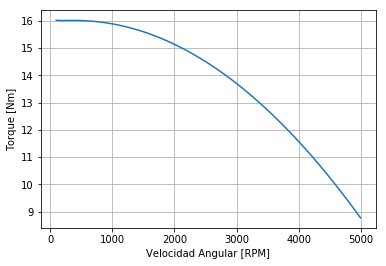

In [89]:
om=np.linspace(10,523,100)
t9=torquemotor(om)
plt.figure()
plt.grid(True)
om=om*(60/(2*np.pi))
plt.plot(om,t9)
plt.xlabel("Velocidad Angular [RPM]")
plt.ylabel("Torque [Nm]")

In [90]:
max(t9)

16.02237892214439

Como se observa en la grafica anterior, el torque entregado por el motor electrico es mayor a bajas velocidades angulares. La relacion no es lineal sino polinomial de grado 3. A su vez a bajas revoluciones (<100 RPM) el motor tiende a a dar un torque constante de 16 Nm

## Graficas para Aceleración

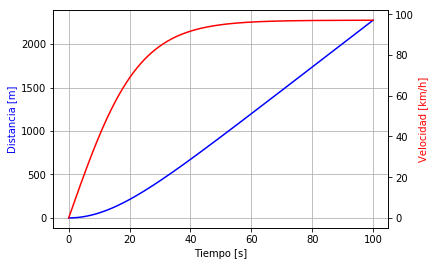

In [91]:
grafacel(pos,sol,t)

A partir del reposo, el **kart** empieza a acelerar de forma rapida, a medida que amuenta su velocidad tiende a una velocidad constante, dicha velocidad final es la velocidad maxima.   
Debido a la integracion numerica se presentan variaciones minimas en el estado estable del **kart**, estos cambios se ven reflejados en la tercera y/o cuarta cifra decimal. Esto ultimo pude con llevar a ligeros errores en la velocidad maxima, pero sobretodo en el tiempo en el que se alcanza la velocidad maxima, ya que segun la integracion numerica la velocidad crece constantemente.   

## Graficas de Frenado

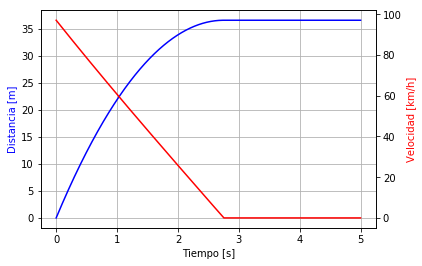

In [92]:
grafacel(pos2,sol2,t2)

A partir de la velocidad maxima, el **kart** empieza a frenar de forma *casi* constante, ya que las mayores fuerzas que intervienen en este proceso no dependen de la velocidad ni la aceleracion del kart.    
Para este proceso se tiene que hacer una corrección en la integracion numerica donde la velocidad y la aceleracion  son cero, o sino el cuerpo empieza a tener una velocidad negativa, lo cual no aplica en este caso.  

### Datos resumidos de la aceleración

In [93]:
Velmax=VelocidadMaxima(sol[:,1])[0]
u=VelocidadMaxima(sol[:,1])[-1]
dist_acel=pos[u]  
t_max=t[u]
print("La velocidad maxima es: %.2f m/s esta es alcanzada en un tiempo de: %.2f s. En ese tiempo recorre una distancia de:  %.2f m" % (Velmax,t_max,dist_acel))

La velocidad maxima es: 26.95 m/s esta es alcanzada en un tiempo de: 92.88 s. En ese tiempo recorre una distancia de:  2081.94 m


### Datos resumidos de la aceleración

In [94]:
Velmin=round(max(sol2[:,1]),3)
dist_fren=max(pos2)
b=0
for i,v in enumerate(sol2[:,1]):
    #print(v,i)
    if ((v>0)&(v>1e-5)):        
       b=i
t_max=t2[b]
print("La velocidad inicial es: %.2f m/s esta es alcanzada en un tiempo de: %.2f s. En ese tiempo recorre una distancia de: %.2f m" % (Velmax,t_max,dist_fren))

La velocidad inicial es: 26.95 m/s esta es alcanzada en un tiempo de: 2.75 s. En ese tiempo recorre una distancia de: 36.54 m


## Aceleracion y frenado

In [95]:
u=VelocidadMaxima(sol[:,1])[-1]
recorrido=[]
t_r=[]
vel_rec=[]
for i in range(0,u+1):
    vel_rec.append(sol[i,1])
    recorrido.append(pos[i])
    t_r.append(t[i])
    
for i in range(0,b+1):
    vel_rec.append(sol2[i,1])
    recorrido.append(max(pos)+pos2[i])
    t_r.append(max(t)+t2[i])
           


print("La distancia recorrida desde una arrancada hasta la velocidad cero es: %.2f [m]. Esta distancia la recorre en un tiempo de %.2f [s]" %(max(recorrido),max(t_r))) 


La distancia recorrida desde una arrancada hasta la velocidad cero es: 2310.28 [m]. Esta distancia la recorre en un tiempo de 102.75 [s]


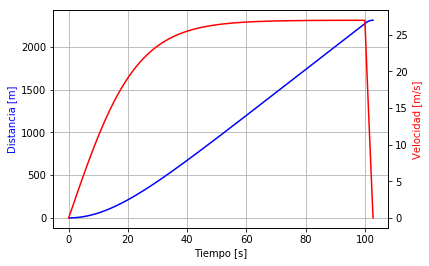

In [96]:
##Grafica 
plt.ion()
plt.plot(t_r,recorrido,'b')
plt.xlabel("Tiempo [s]")
plt.ylabel("Distancia [m]",color='b')
plt.grid(True)
plt.twinx()
plt.plot(t_r,vel_rec,'r')
plt.ylabel("Velocidad [m/s]",color='r')
plt.legend()

En la grafica anterior, se resume el proceso de aceleración desde el resposo hasta la velocidad maxima y frenado esde la velocidad maxima hasta el reposo. En ella se muestra la posición y aceleración a traves del tiempo.   
Se ve que el proceso de aceleración es extremadamente lento en comparación al proceso de frenado. 

# Analisis con diferentes caracteristicas del automovil
***
Para este proceso se llevara a cabo los mismos calculos antes mostrados para diferentes caracteristacas del automovil

## Relacion de sistema de trasmisión 

In [97]:
Velocidades=[]
DistanciasAcel=[]
Tiempo_Acel=[]
Tiempo_Freno=[]
DistanciaFreno=[]
ngs=[1.9,3.2,3.4,4]
masas=np.linspace(149,153,20)
mu_cs=np.linspace(0.5,1,5)

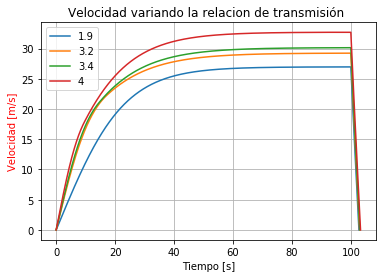

In [98]:
# Definicion de variables
for ng in ngs:
    x_0=0
    v_0=0
    a_0=0
    c_ini = [x_0,v_0]
    t=np.arange(t_in,t_acel,deltat)
    acel=[]
    vel=[]
    pos=[]
    pos.append(x_0) 
    v=v_0
    a=a_0
    acel.append(a)
    vel.append(v)
   

    ## Solucion
    sol = odeint(aceleracion,c_ini,t)
    vel=sol[:,1]
    posicion(sol[:,1],pos,t)
    ##
    t2=np.arange(t_in,t_fren,deltat)
    x_f=0
    v_f=max(vel)
    pos2=[]
    pos2.append(x_f)
    vel2=[]
    acel2=[]
    acel2.append(acel[len(acel)-1])
    c_ini2=[x_f,v_f]
    ##
    sol2 = odeint(frenado,c_ini2,t2)
    posicion(sol2[:,1],pos2,t2)
    ##
    Velmax=VelocidadMaxima(sol[:,1])[0]
    Velocidades.append(Velmax)
    u=VelocidadMaxima(sol[:,1])[-1];
    dist_acel=pos[u]
    DistanciasAcel.append(dist_acel)
    t_max=t[u]
    Tiempo_Acel.append(t_max)
    ##
    Velmin=max(sol2[:,1])
    dist_fren=max(pos2)
    b=0
    for i,v in enumerate(sol2[:,1]):
        #print(v,i)
        if ((v>0)&(v>1e-5)):        
           b=i
    t_max2=t2[b]
    DistanciaFreno.append(dist_fren)
    Tiempo_Freno.append(t_max2)
    u=VelocidadMaxima(sol[:,1])[-1]
    recorrido=[]
    t_r=[]
    vel_rec=[]
    for i in range(0,u+1):
        vel_rec.append(sol[i,1])
        recorrido.append(pos[i])
        t_r.append(t[i])

    for i in range(0,b+1):
        vel_rec.append(sol2[i,1])
        recorrido.append(max(pos)+pos2[i])
        t_r.append(max(t)+t2[i])
    
    #plt.ion()
    #lt.plot(t_r,recorrido,label=ng)
    plt.xlabel("Tiempo [s]")
   # plt.ylabel("Distancia [m]",color='b')
    plt.grid(True)
    #plt.legend(loc='best')
    #plt.twinx()
    plt.plot(t_r,vel_rec,label=ng)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Velocidad [m/s]",color='r')
    plt.legend(loc='best')
    plt.title("Velocidad variando la relacion de transmisión ")
    


Para la grafica anterior se puede observar que a mayor relación de trasmision se alcanza una velocidad mucho mayor, pero a su vez con un tiempo mayor para llegar a dicha velocidad. Por otro lado, se tiene que el tiempo de frenado (*hasta llegar a reposo*) tambien es *proporcional* a la relación de trasmición usada

In [99]:
d={"Tiempo de Frenado[s]":Tiempo_Freno,"Distancia de Frenado[m]":DistanciaFreno,'Velocidad Maxima [m/s]':Velocidades,'Distancias Aceleración[m]': DistanciasAcel,"Tiempo Velocidad Maxima [s]":Tiempo_Acel}
Resultados=pd.DataFrame(data=d,index=ngs)
Resultados

,Distancia de Frenado[m],Distancias Aceleración[m],Tiempo Velocidad Maxima [s],Tiempo de Frenado[s],Velocidad Maxima [m/s]
1.9,36.538590,2081.943116,92.883,2.753,26.949577
3.2,42.630796,2475.287811,97.218,2.970,29.226727
3.4,45.154354,2506.635910,95.879,3.055,30.126419
4.0,52.633377,2650.112177,93.830,3.293,32.682147


## Masa del kart

In [100]:
Velocidades=[]
DistanciasAcel=[]
Tiempo_Acel=[]
Tiempo_Freno=[]
DistanciaFreno=[]
ngs=[2,3.2,3.4,4]
masas=np.linspace(149,153,5)
mu_cs=np.linspace(0.5,1,5)

In [101]:
# Definicion de variables
for masa in masas:
    x_0=0
    v_0=0
    a_0=0
    c_ini = [x_0,v_0]
    t=np.arange(t_in,t_acel,deltat)
    acel=[]
    vel=[]
    pos=[]
    pos.append(x_0) 
    v=v_0
    a=a_0
    acel.append(a)
    vel.append(v)
   

    ## Solucion
    sol = odeint(aceleracion,c_ini,t)
    vel=sol[:,1]
    posicion(sol[:,1],pos,t)
    ##
    t2=np.arange(t_in,t_fren,deltat)
    x_f=0
    v_f=max(vel)
    pos2=[]
    pos2.append(x_f)
    vel2=[]
    acel2=[]
    acel2.append(acel[len(acel)-1])
    c_ini2=[x_f,v_f]
    ##
    sol2 = odeint(frenado,c_ini2,t2)
    posicion(sol2[:,1],pos2,t2)
    ##
    Velmax=VelocidadMaxima(sol[:,1])[0]
    Velocidades.append(Velmax)
    u=VelocidadMaxima(sol[:,1])[-1];
    dist_acel=pos[u]
    DistanciasAcel.append(dist_acel)
    t_max=t[u]
    Tiempo_Acel.append(t_max)
    ##
    Velmin=max(sol2[:,1])
    dist_fren=max(pos2)
    b=0
    for i,v in enumerate(sol2[:,1]):
        #print(v,i)
        if ((v>0)&(v>1e-5)):        
           b=i
    t_max2=t2[b]
    DistanciaFreno.append(dist_fren)
    Tiempo_Freno.append(t_max2)
    

In [102]:
d={"Tiempo de Frenado[s]":Tiempo_Freno,"Distancia de Frenado[m]":DistanciaFreno,'Velocidad Maxima [m/s]':Velocidades,'Distancias Aceleración[m]': DistanciasAcel,"Tiempo Velocidad Maxima [s]":Tiempo_Acel}
Resultados=pd.DataFrame(data=d,index=masas)
Resultados

,Distancia de Frenado[m],Distancias Aceleración[m],Tiempo Velocidad Maxima [s],Tiempo de Frenado[s],Velocidad Maxima [m/s]
149.0,51.762619,2838.649146,99.386,3.238,32.690289
150.0,52.052937,2696.662490,95.113,3.257,32.685339
151.0,52.343189,2798.721532,98.306,3.275,32.688294
152.0,52.633377,2650.112177,93.830,3.293,32.682147
153.0,52.923529,2611.398619,92.716,3.311,32.679546


Cuando variamos ligeramente la masa del kart, * aunque es un poco dificil se puede lograr con cambios minimos como por ejemplo cambiando la suspención y el sistemas de baterias*, vemos que  las vvariables que se afectan  principalmente son:
* El tiempo en alcanzar la velocidad maxima
* Distancia reocrrida hasta llegar a la velocidad maxima 
* Tiempo de Frenado  

A mayor masa del **kart** se obtiene una menor velocidad maxima y un mayor tiempo de frenado. Por eso es recomendable tratar de reducir lo maximo posible la masa del conjunto *kart-conductor*

## Coficiente de adherencia entre las llantas y el asfalto. 

In [103]:
Velocidades=[]
DistanciasAcel=[]
Tiempo_Acel=[]
Tiempo_Freno=[]
DistanciaFreno=[]
mu_cs=[0.5,0.75,1]

In [104]:

# Definicion de variables
for mu_c in mu_cs:
    x_0=0
    v_0=0
    a_0=0
    c_ini = [x_0,v_0]
    t=np.arange(t_in,t_acel,deltat)
    acel=[]
    vel=[]
    pos=[]
    pos.append(x_0) 
    v=v_0
    a=a_0
    acel.append(a)
    vel.append(v)
   

    ## Solucion
    sol = odeint(aceleracion,c_ini,t)
    vel=sol[:,1]
    posicion(sol[:,1],pos,t)
    ##
    t2=np.arange(t_in,t_fren,deltat)
    x_f=0
    v_f=max(vel)
    pos2=[]
    pos2.append(x_f)
    vel2=[]
    acel2=[]
    acel2.append(acel[len(acel)-1])
    c_ini2=[x_f,v_f]
    ##
    sol2 = odeint(frenado,c_ini2,t2)
    posicion(sol2[:,1],pos2,t2)
    ##*
    Velmax=VelocidadMaxima(sol[:,1])[0]
    Velocidades.append(Velmax)
    u=VelocidadMaxima(sol[:,1])[-1];
    dist_acel=pos[u]
    DistanciasAcel.append(dist_acel)
    t_max=t[u]
    Tiempo_Acel.append(t_max)
    ##
    Velmin=max(sol2[:,1])
    dist_fren=max(pos2)
    b=0
    for i,v in enumerate(sol2[:,1]):
        #print(v,i)
        if ((v>0)&(v>1e-5)):        
           b=i
    t_max2=t2[b]
    DistanciaFreno.append(dist_fren)
    Tiempo_Freno.append(t_max2)


In [105]:
d={"Tiempo de Frenado[s]":Tiempo_Freno,"Distancia de Frenado[m]":DistanciaFreno,'Velocidad Maxima [m/s]':Velocidades,'Distancias Aceleración[m]': DistanciasAcel,"Tiempo Velocidad Maxima [s]":Tiempo_Acel}
Resultados=pd.DataFrame(data=d,index=mu_cs)
Resultados

,Distancia de Frenado[m],Distancias Aceleración[m],Tiempo Velocidad Maxima [s],Tiempo de Frenado[s],Velocidad Maxima [m/s]
0.50,98.750226,2611.398619,92.716,4.999,32.679546
0.75,71.221877,2611.398619,92.716,4.492,32.679546
1.00,52.923529,2611.398619,92.716,3.311,32.679546


+

Al revisar el comportamiento de las variables importantes con el cambio del coeficiente de adheción, se los procesos afectados son los relacionados al frenado. A menor coeficiente, se tiene una mayor distancia y mayor tiempo en el frenado.

# Conclusiones y recomendaciones 
* Se recomienda usar en el kart una relacion de trasmision intermedia como **3.4**, tratar de reducir la masa del conjunto *kart-conductor* lo maximo posible y usar llantas con la el mayor coeficiente de adherencia posible.